Importação das bibliotecas utilizadas

In [2]:
import csv
import shutil
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import os
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import argparse
import cv2
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
import glob
import zipfile
import time

order_list = ['negativo','positivo']

IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

Utilização do drive para salvar os arquivos de configuração e os resultados obtidos

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Descompacta as imagens da base GUNRAJ et al. para treinamento validação e teste β

In [3]:
path = '/content/drive/MyDrive/TCC/archive.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

O código a seguir monta os arquivos de configuração para cada fold. Precisa ser executado apenas uma vez

In [ ]:
txt_file = r"/content/drive/MyDrive/TCC/dataset_map.txt"
csv_file = r"/content/training_files.csv"

in_txt = csv.reader(open(txt_file, "r"), delimiter = " ", quotechar=" ")
out_csv = csv.writer(open(csv_file, 'w', newline='\n'),delimiter=',', quotechar=' ', quoting=csv.QUOTE_MINIMAL)

out_csv.writerows(in_txt)

Lê o arquivo com todas as classes do trabalho original e faz o remapeamento para 2 classes

In [4]:
training_files = pd.read_csv(r'/content/drive/MyDrive/TCC/training_files.csv')

dataset = [] #fazer o append no dataframe depois

for i in range(training_files['label'].size):
  if training_files['label'][i] == 2: #2 representa covid-19 - COVID POSITIVO
    aux = 'positivo' #representando 'covid' -> covid
  else:
    aux = 'negativo' #representando 'pneumonia' e 'normal' como -> NAO COVID
  dataset.append([training_files['filename'][i], aux])

dataset = pd.DataFrame(dataset, columns=['filename', 'label'])

m = ~dataset['filename'].duplicated(keep='first')
dataset = dataset[m]

dataset

,filename,label
0,NCP_96_1328_0032.png,positivo
1,NCP_96_1328_0035.png,positivo
2,NCP_96_1328_0036.png,positivo
3,NCP_96_1328_0037.png,positivo
4,NCP_96_1328_0038.png,positivo
...,...,...
194917,radiopaedia_40_86625_0-0078.png,positivo
194918,radiopaedia_40_86625_0-0079.png,positivo
194919,radiopaedia_40_86625_0-0080.png,positivo
194920,radiopaedia_40_86625_0-0081.png,positivo


Exibe a distribuição total das imagens entre as classes envolvidas

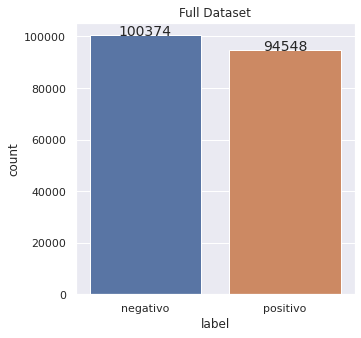

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x='label', data = dataset, order=order_list).set_title("Full Dataset")
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 14)

Divide os dados do trabalho original para 80% treinamento e 20% validação

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

Registra em memória os conjuntos de treinamento e teste divididos anteriormente

In [ ]:
#grava as divisões treinamento e testes na memoria
train.to_csv('/content/drive/MyDrive/TCC/train.csv', index=False)
test.to_csv('/content/drive/MyDrive/TCC/test.csv', index=False)

Consulta das configurações salvas para treinamento

In [6]:
##le do drive
train = pd.read_csv(r'/content/drive/MyDrive/TCC/train.csv')
print(train)

                         filename     label
0        HUST-Patient198-0226.png  positivo
1        HUST-Patient357-0146.png  positivo
2           CP_1122_3340_0096.png  negativo
3       HUST-Patient1391-0178.png  positivo
4         Normal_795_230_0068.png  negativo
...                           ...       ...
155932    Normal_770_205_0090.png  negativo
155933  HUST-Patient1382-0193.png  positivo
155934      NCP_460_2074_0059.png  positivo
155935      NCP_845_2363_0320.png  positivo
155936  Normal_1742_1055_0053.png  negativo

[155937 rows x 2 columns]


Exibe o gráfico com a distruição entre as classes das imagens do conjunto de treinamento

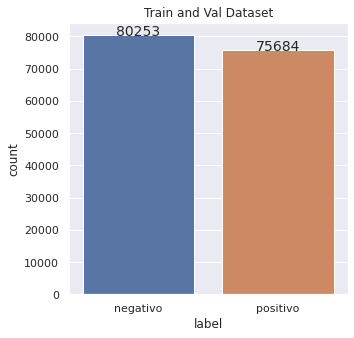

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x='label', data = train, order=order_list).set_title("Train and Val Dataset")
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 14)

Registra em memória a configuração de arquivos de treinamento e validação para cada fold. Precisa ser executado apenas 1 vez

In [ ]:
X_train = train['filename']
Y_train = train['label']

kf = KFold(n_splits = 5, shuffle = True)

fold = 1
for train_index, val_index in kf.split(X_train ,Y_train):

  train_data = train.iloc[train_index]
  val_data = train.iloc[val_index]

  train_data.to_csv('/content/drive/MyDrive/TCC/config_folds/train_fold_' + str(fold) + '.csv', index=False)
  val_data.to_csv('/content/drive/MyDrive/TCC/config_folds/val_fold_' + str(fold) + '.csv', index=False)

  fold += 1

Lê da memória o conjunto de dados para teste do modelo

In [8]:
test = pd.read_csv('/content/drive/MyDrive/TCC/test.csv')
print(test)

                        filename     label
0           CP_597_2959_0221.png  negativo
1       HUST-Patient820-0145.png  positivo
2          CP_1440_3950_0010.png  negativo
3        Normal_778_213_0112.png  negativo
4       Normal_1720_996_0043.png  negativo
...                          ...       ...
38980      NCP_498_2152_0064.png  positivo
38981  Normal_3910_5446_0053.png  negativo
38982   HUST-Patient257-0204.png  positivo
38983      CP_3643_5602_0114.png  negativo
38984    Normal_797_232_0075.png  negativo

[38985 rows x 2 columns]


Exibe a distribuição entre classes do conjunto de teste

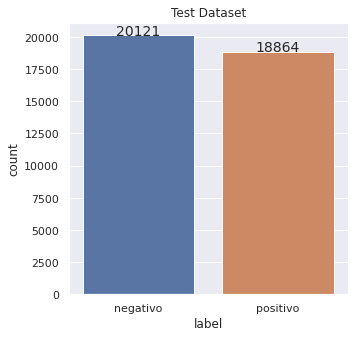

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(ax=ax, x='label', data = test,order=order_list).set_title("Test Dataset")

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 14)

Cria o arquivo de resultados
Deve ser executado apenas na primeira vez



In [ ]:
#executar 1 vez
with open('/content/drive/MyDrive/TCC/resultados/resultados.csv', 'w') as arquivo_csv:
    colunas = ['Fold', 'Loss', 'TN','FP','FN','TP', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1-score', 'AUROC', 'TPR', 'FPR' ]
    escrever = csv.DictWriter(arquivo_csv, fieldnames=colunas, delimiter=',', lineterminator='\n')
    escrever.writeheader()

    arquivo_csv.close()

Cria o diretório onde as imagens redimensionadas irão ficar

In [10]:
mkdir dataset

Verifica a presença de arquivos que não sejam imagens

In [11]:
#verificação se existem arquivos diferentes de png no dataset do trabalho de gunraj
cont_dif_png = 0

for i in dataset['filename']:
  file_name = os.path.basename(i)
  if os.path.splitext(file_name)[1] != '.png':
    cont_dif_png += 1

print(cont_dif_png)

0


Redimensiona todos os arquivos de Gunraj

In [12]:
#alternativa com openCV 
datasetPath = '/content/dataset/'
aux = 0

for imagePath in dataset['filename']:
  src = cv2.imread("/content/2A_images/"+ imagePath)
  output = cv2.resize(src, (224,224))
  file_name = os.path.basename(imagePath)
  cv2.imwrite(datasetPath + file_name,output)
  
  aux += 1

print(aux)

194922


In [13]:
#verifica se na pasta final com os dados existe arquivos repetidos conj gunraj
dataset_final = glob.glob('/content/dataset/*.*')

df10 = []
for i in dataset_final:
  df10.append(os.path.basename(i))

df10 = pd.DataFrame(df10, columns=['filename'])

m = ~df10['filename'].duplicated(keep='first')
df10 = df10[m]
df10

,filename
0,CP_1139_3357_0236.png
1,HUST-Patient1309-0235.png
2,NCP_188_1520_0053.png
3,volume-covid19-A-0073_ct-0039.png
4,Normal_3842_5354_0164.png
...,...
194917,volume-covid19-A-0644-0040.png
194918,normal1_patient202_SR_2_IM00036.png
194919,CP_3733_5674_0098.png
194920,HUST-Patient293-0256.png


Importação do conjunto alpha

In [14]:
path = '/content/drive/MyDrive/TCC/ct_dataset_tcc_gregory_v_1_0.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

import glob
covid_pos = glob.glob('/content/dataset_ct_tcc_gregory_v1/CT_COVID/*.*')
covid_neg = glob.glob('/content/dataset_ct_tcc_gregory_v1/CT_NonCOVID/*.*')

dado1={'filename':covid_neg,'label':'negativo'}
dado2={'filename':covid_pos,'label':'positivo'}
dado1df = pd.DataFrame(dado1)
dado2df = pd.DataFrame(dado2)

In [15]:
conjalpha = pd.DataFrame(columns=['filename','label'])

In [16]:
k = 0

In [17]:
for i in range(dado1df['filename'].size):
  conjalpha.loc[k] = [dado1df['filename'][i],dado1df['label'][i]]
  k += 1 

In [18]:
for i in range(dado2df['filename'].size):
  conjalpha.loc[k] = [dado2df['filename'][i],dado2df['label'][i]]
  k += 1 

Cria o diretório onde as imagens do conjunto aplha irão ficar depois de redimensionadas

In [19]:
mkdir conjalpha

Verificação se existem arquivos diferentes de imagens no conjunto alpha

In [20]:
#verificação se existem arquivos diferentes de png no dataset do trabalho de zhao
cont_dif_png = 0

for i in conjalpha['filename']:
  file_name = os.path.basename(i)
  if os.path.splitext(file_name)[1] != '.png':
    cont_dif_png += 1

print(cont_dif_png)

201


Faz a operação de resize apenas nos arquivos em formato png e desconsidera os outros

In [21]:
datasetPath = '/content/conjalpha/'
aux = 0
#rep_convertidos = 0

for imagePath in conjalpha['filename']:
  file_name = os.path.basename(imagePath)
  if os.path.splitext(file_name)[1] != '.png':
    continue
  else:
    src = cv2.imread(imagePath)
    output = cv2.resize(src, (224,224))
    cv2.imwrite(datasetPath + file_name,output)
  aux += 1

print(aux)

541


In [22]:
conjalpha

,filename,label
0,/content/dataset_ct_tcc_gregory_v1/CT_NonCOVID...,negativo
1,/content/dataset_ct_tcc_gregory_v1/CT_NonCOVID...,negativo
2,/content/dataset_ct_tcc_gregory_v1/CT_NonCOVID...,negativo
3,/content/dataset_ct_tcc_gregory_v1/CT_NonCOVID...,negativo
4,/content/dataset_ct_tcc_gregory_v1/CT_NonCOVID...,negativo
...,...,...
737,/content/dataset_ct_tcc_gregory_v1/CT_COVID/20...,positivo
738,/content/dataset_ct_tcc_gregory_v1/CT_COVID/20...,positivo
739,/content/dataset_ct_tcc_gregory_v1/CT_COVID/20...,positivo
740,/content/dataset_ct_tcc_gregory_v1/CT_COVID/20...,positivo


In [23]:
for imagePath in conjalpha['filename']:
  file_name = os.path.basename(imagePath)
  conjalpha.loc[conjalpha.filename==imagePath,'filename']=file_name
  
conjalpha

,filename,label
0,1921.png,negativo
1,26%1.jpg,negativo
2,20.jpg,negativo
3,52%1.jpg,negativo
4,14%2.jpg,negativo
...,...,...
737,2020.02.10.20021584-p6-52%9.png,positivo
738,2020.02.25.20021568-p23-108%10.png,positivo
739,2020.03.16.20035105-p6-64-2.png,positivo
740,2020.03.22.20040782-p24-1533-5.png,positivo


In [24]:
#verifica se na pasta final com os dados existe arquivos repetidos
dataset_final = glob.glob('/content/conjalpha/*.*')

df12 = []
for i in dataset_final:
  df12.append(os.path.basename(i))

df12 = pd.DataFrame(df12, columns=['filename'])

m = ~df12['filename'].duplicated(keep='first')
df12 = df12[m]
df12

,filename
0,2020.02.19.20025023-p20-93%0.png
1,1921.png
2,2020.02.10.20021584-p6-52%6.png
3,2020.03.11.20033159-p12-45%2.png
4,2020.02.10.20021584-p6-52%1.png
...,...
536,2020.02.10.20021584-p6-52%9.png
537,2020.02.25.20021568-p23-108%10.png
538,2020.03.16.20035105-p6-64-2.png
539,2020.03.22.20040782-p24-1533-5.png


In [25]:
df14 = []

k = 0
for i in range(conjalpha['label'].size):
  for j in range(df12['filename'].size):
    if conjalpha['filename'][i] == df12['filename'][j]:
      df14.append([conjalpha['filename'][i],conjalpha['label'][i]])
      break
    else:
      continue
#verifica se o arquivo do conjunto original foi redimensionado no formato png e 
#ignora o restante dos arquivos em outros formatos
df14 = pd.DataFrame(df14, columns=['filename','label']) 
df14

,filename,label
0,1921.png,negativo
1,577.png,negativo
2,1058.png,negativo
3,1060.png,negativo
4,378.png,negativo
...,...,...
536,2020.02.10.20021584-p6-52%9.png,positivo
537,2020.02.25.20021568-p23-108%10.png,positivo
538,2020.03.16.20035105-p6-64-2.png,positivo
539,2020.03.22.20040782-p24-1533-5.png,positivo


In [26]:
#verificação se existem arquivos diferentes de png no dataset do trabalho de zhao
cont_dif_png = 0

for i in df14['filename']:
  file_name = os.path.basename(i)
  if os.path.splitext(file_name)[1] != '.png':
    cont_dif_png += 1

print(cont_dif_png)

0


Exibe a distribuição das imagens entre as classes para o conjunto de teste alpha

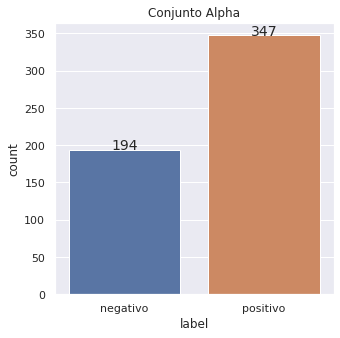

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x='label', data = df14, order=order_list).set_title("Conjunto Alpha")
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 14)

# Visualização das imagens

In [ ]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

#0           CP_597_2959_0221.png  negativo
#1       HUST-Patient820-0145.png  positivo

%matplotlib inline
pil_im = Image.open('/content/2A_images/CP_597_2959_0221.png', 'r')
pil_im2 = Image.open('/content/dataset/CP_597_2959_0221.png', 'r')
#imshow(np.asarray(pil_im))
display(pil_im)

In [ ]:
pil_im2

In [ ]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

#0           CP_597_2959_0221.png  negativo
#1       HUST-Patient820-0145.png  positivo

%matplotlib inline
pil_im = Image.open('/content/2A_images/HUST-Patient820-0145.png', 'r')
pil_im2 = Image.open('/content/dataset/HUST-Patient820-0145.png', 'r')
#imshow(np.asarray(pil_im))
display(pil_im)

In [ ]:
pil_im2

# Definição da arquitetura do modelo

Define e compila a arquitetura do modelo de rede neural convolucional utilizando transfer learning

In [28]:
def get_model():

  base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.models.Model(inputs, outputs)

  model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.TrueNegatives(name='tn'),tf.keras.metrics.FalsePositives(name='fp'),
                     tf.keras.metrics.FalseNegatives(name='fn'),tf.keras.metrics.TruePositives(name='tp'),
                     tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall'),
                     tf.keras.metrics.AUC(name='auc')]
            )

  return model

In [29]:
final_model = get_model()
final_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable

Exibe o diagrama da arquitetura final do modelo

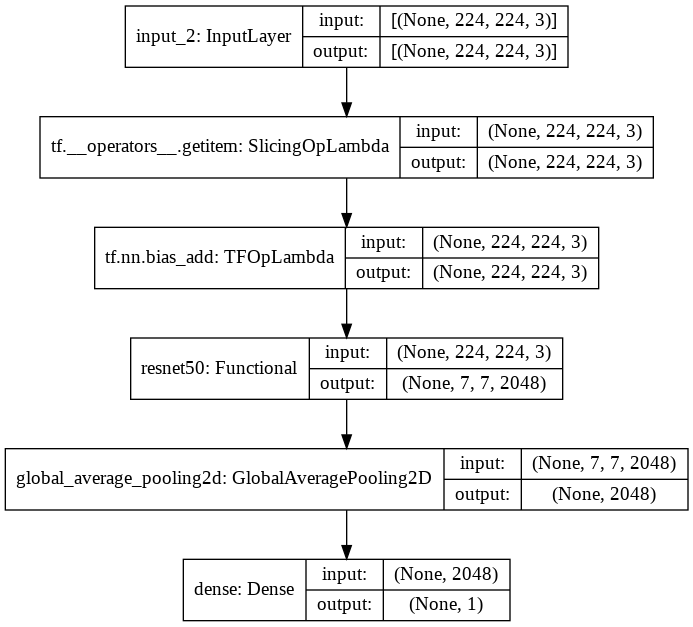

In [30]:
tf.keras.utils.plot_model(final_model, show_shapes=True)

Salva o JSON com a arquitetura do modelo e os pesos do imagenet

In [ ]:
# serialize model to JSON
model_json = final_model.to_json()
with open("/content/drive/MyDrive/TCC/modelo/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
final_model.save_weights("/content/drive/MyDrive/TCC/modelo/weights_imagenet.h5")
print("Saved model to disk")

Função get_model com o carregamento da arquitetura direto do drive

In [ ]:
def get_model():
  # load json and create model
  json_file = open(r'/content/drive/MyDrive/TCC/modelo/model.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = tf.keras.models.model_from_json(loaded_model_json)
  # load weights
  loaded_model.load_weights(r'/content/drive/MyDrive/TCC/saved_models/weights_1')
  print("Loaded model from disk")

  loaded_model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=[tf.keras.metrics.BinaryAccuracy()])

  return loaded_model

Define o generator

In [ ]:
idg = tf.keras.preprocessing.image.ImageDataGenerator()

Carrega o arquivo do fold em questão para treinamento

In [ ]:
save_dir = '/content/drive/MyDrive/TCC/saved_models/'
fold_var = 1


training_data = pd.read_csv(r'/content/drive/MyDrive/TCC/config_folds/train_fold_'+str(fold_var)+'.csv')
validation_data = pd.read_csv(r'/content/drive/MyDrive/TCC/config_folds/val_fold_'+str(fold_var)+'.csv')

Define os dataframes que irão passar as imagens, de acordo com o filename e a classe, ao modelo

In [ ]:
train_data_generator = idg.flow_from_dataframe(training_data, directory = '/content/dataset',
						       x_col = "filename", y_col = "label",
						       class_mode = "binary", shuffle = True, target_size=(224,224), batch_size=64)
  
val_data_generator  = idg.flow_from_dataframe(validation_data, directory = '/content/dataset',
                  x_col = "filename", y_col = "label",
                  class_mode = "binary", shuffle = True, target_size=(224,224), batch_size=64)

Found 124749 validated image filenames belonging to 2 classes.
Found 31188 validated image filenames belonging to 2 classes.


In [ ]:
val_data_generator.class_indices

{'negativo': 0, 'positivo': 1}

É definida uma instância do modelo e o treinamento para o fold definido é realizado

In [ ]:
model = get_model()


keras_callbacks = [
      ModelCheckpoint(save_dir + 'weights_fold_'+str(fold_var), monitor='val_loss', save_best_only=True, mode='min', 
                      save_weights_only=True, verbose = 1)
                  ]
	# This saves the best model

print('------------------------------------------------------------------------')
print(f'Training for fold {fold_var} ...')

  # Train the Model
history = model.fit(train_data_generator,
                      epochs=10,
                      verbose=1,
                      validation_data=val_data_generator,
                      callbacks=keras_callbacks)

Criação de nova instância para evaluate do modelo

In [ ]:
model = get_model()

Carga dos pesos que obtiveram melhor resultado durante o treinamento

In [ ]:
model.load_weights(save_dir + 'weights_fold_'+str(fold_var))

Evaluate do modelo

In [ ]:
# evaluate
scores = model.evaluate(val_data_generator)
#pos 0 = loss --- pos 1 = acc
predicted_classes_prob_train = model.predict(val_data_generator)

488/488 [==============================] - 69s 139ms/step - loss: 0.0595 - tn: 15458.0000 - fp: 441.0000 - fn: 271.0000 - tp: 15017.0000 - accuracy: 0.9772 - precision: 0.9715 - recall: 0.9823 - auc: 0.9977


Visualização das métricas

In [ ]:
print('Loss: {} \n TN: {} \n FP: {} \n FN: {} \n TP: {} \n Accuracy: {} \n Precision: {} \n Recall: {} \n AUC: {}'.format(scores[0],scores[1],scores[2],scores[3],scores[4],scores[5],scores[6],scores[7],scores[8]))

In [ ]:
tn = scores[1]
fp = scores[2]
fn = scores[3]
tp = scores[4]

accuracy_train = (tp+tn)/(tp+tn+fp+fn)

sensitivity_train = tp/(tp+fn)
recall_train = tp/(tp+fn)

specificity_train = tn/(tn+fp)

precision_train = tp/(tp+fp)
f1_score_train = (2*(precision_train*recall_train))/(precision_train + recall_train)

tpr_train = tp/(tp+fn)
fpr_train = fp/(fp+tn)

print(accuracy_train)
print(sensitivity_train)
print(specificity_train)
print(precision_train)
print(recall_train)
print(f1_score_train)

print(tpr_train)
print(fpr_train)

Registra em memória os resultados para do treinamento para o fold em questão

In [ ]:
with open(r'/content/drive/MyDrive/TCC/resultados/resultados.csv', 'a') as arquivo_csv:
    colunas = ['Fold', 'Loss', 'TN','FP','FN','TP', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1-score', 'AUROC', 'TPR', 'FPR' ]
    escrever = csv.DictWriter(arquivo_csv, fieldnames=colunas, delimiter=',', lineterminator='\n')
    escrever.writerow({'Fold': str(fold_var), 
                       'Loss': scores[0], 
                       'TN': scores[1],
                       'FP': scores[2],
                       'FN': scores[3],
                       'TP': scores[4], 
                       'Accuracy': scores[5], 
                       'Sensitivity': scores[7], 
                       'Specificity': specificity_train, 
                       'Precision': scores[6], 
                       'F1-score': f1_score_train,
                       'AUROC': scores[8], 
                       'TPR': tpr_train, 
                       'FPR': fpr_train
                       })
    arquivo_csv.close()

Monta e salva em memória os gráficos de loss e accuracy para o fold no qual foi realizado o treinamento

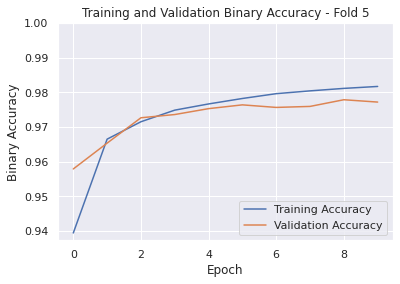

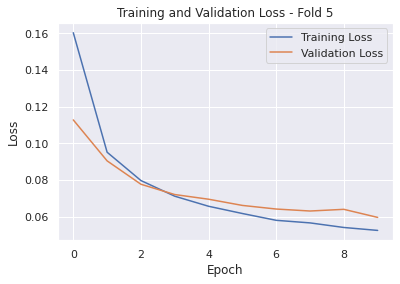

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Binary Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Binary Accuracy - Fold ' +str(fold_var))
plt.xlabel('Epoch')
plt.savefig('/content/drive/MyDrive/TCC/graficos_folds/Training and Validation Accuracy_Fold_'+str(fold_var)+'.png')
plt.show()


plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Fold ' +str(fold_var))
plt.xlabel('Epoch')
plt.savefig('/content/drive/MyDrive/TCC/graficos_folds/Training and Validation Loss_Fold_'+str(fold_var)+'.png')
plt.show()

In [ ]:
#usando esse
plt.plot(fpr_keras_train, tpr_keras_train, lw = 2, label = 'ROC AUC: {:.3f}'.format(auc_keras_train))
plt.plot([0, 1], [0, 1],
         linestyle = '--',
         color = (0.6, 0.6, 0.6))#,
         #label = 'Random guessing')
#plt.plot([0, 0, 1], [0, 1, 1],
#         linestyle = ':',
#         color = 'black', 
#         label = 'Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Training ROC AUC - Fold ' +str(fold_var))
plt.legend(loc = "lower right")
#plt.tight_layout()
plt.savefig('/content/drive/MyDrive/TCC/graficos_folds/Training ROC AUC_Fold_'+str(fold_var)+'.png')
plt.show()

Exibe os resultados de todos os folds já treinados até o momento

In [5]:
result = pd.read_csv(r'/content/drive/MyDrive/TCC/resultados/resultados.csv')
result = pd.DataFrame(result)
result

,Fold,Loss,TN,FP,FN,TP,Accuracy,Sensitivity,Specificity,Precision,F1-score,AUROC,TPR,FPR
0,1,0.051881,15670.0,336.0,226.0,14956.0,0.981980,0.985114,0.979008,0.978028,0.981558,0.998090,0.985114,0.020992
1,2,0.057544,15874.0,247.0,378.0,14689.0,0.979960,0.974912,0.984678,0.983463,0.979169,0.997576,0.974912,0.015322
2,3,0.055389,15575.0,407.0,211.0,14994.0,0.980184,0.986123,0.974534,0.973573,0.979808,0.998002,0.986123,0.025466
3,4,0.057336,15865.0,380.0,282.0,14660.0,0.978773,0.981127,0.976608,0.974734,0.977920,0.997741,0.981127,0.023392
4,5,0.059549,15458.0,441.0,271.0,15017.0,0.977170,0.982274,0.972262,0.971471,0.976843,0.997708,0.982274,0.027738


Media das metricas do treinamento

In [12]:
print('Loss: {:.3f}'.format(result['Loss'].mean()))
print('TN: {:.3f}'.format(result['TN'].mean()))
print('FP: {:.3f}'.format(result['FP'].mean()))
print('FN: {:.3f}'.format(result['FN'].mean()))
print('TP: {:.3f}'.format(result['TP'].mean()))
print('Accuracy: {:.3f}'.format(result['Accuracy'].mean()))
print('Sensitivity: {:.3f}'.format(result['Sensitivity'].mean()))
print('Specificity: {:.3f}'.format(result['Specificity'].mean()))
print('Precision: {:.3f}'.format(result['Precision'].mean()))
print('F1-score: {:.3f}'.format(result['F1-score'].mean()))
print('AUROC: {:.3f}'.format(result['AUROC'].mean()))

Loss: 0.056
TN: 15688.400
FP: 362.200
FN: 273.600
TP: 14863.200
Accuracy: 0.980
Sensitivity: 0.982
Specificity: 0.977
Precision: 0.976
F1-score: 0.979
AUROC: 0.998


# Testes

-> Apenas ao final do treinamento pelos 5 folds

Define generator para testes

In [32]:
idg = tf.keras.preprocessing.image.ImageDataGenerator()

Definição das informações passadas ao modelo pelo dataframe referente ao teste beta

In [33]:
test_data_generator  = idg.flow_from_dataframe(test, directory = '/content/dataset/',
							x_col = "filename",  y_col = "label",
							class_mode = "binary", shuffle = False, target_size=(224,224), batch_size=1)

Found 38985 validated image filenames belonging to 2 classes.


In [34]:
test_data_generator.class_indices

{'negativo': 0, 'positivo': 1}

Carga do modelo apenas para previsões

In [ ]:
#apenas para predict
json_file = open(r'/content/drive/MyDrive/TCC/modelo/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights
loaded_model.load_weights(r'/content/drive/MyDrive/TCC/saved_models/weights_fold_3')
print("Loaded model from disk")

Nova instância do modelo para testes

In [35]:
#esse é pro evaluate
loaded_model = get_model()
# load weights
loaded_model.load_weights(r'/content/drive/MyDrive/TCC/saved_models/weights_fold_3')
print("Loaded model from disk")

Loaded model from disk


Teste beta

In [36]:
eval_teste = loaded_model.evaluate(test_data_generator)

38985/38985 [==============================] - 574s 14ms/step - loss: 0.0575 - tn: 19583.0000 - fp: 538.0000 - fn: 278.0000 - tp: 18586.0000 - accuracy: 0.9791 - precision: 0.9719 - recall: 0.9853 - auc: 0.9978


In [37]:
predicted_prob_test = loaded_model.predict(test_data_generator)
#predicted = (predicted > 0.5)
#predicted = np.where(predicted>0.5, 'N-COVID', 'COVID-19')
predicted_test = predicted_prob_test
predicted_test = np.where(predicted_test>0.5, 1, 0)

Visualização das métricas para o teste beta

In [38]:
print('Loss: {} \n TN: {} \n FP: {} \n FN: {} \n TP: {} \n Accuracy: {} \n Precision: {} \n Recall: {} \n AUC: {}'.format(eval_teste[0],eval_teste[1],eval_teste[2],eval_teste[3],eval_teste[4],eval_teste[5],eval_teste[6],eval_teste[7],eval_teste[8]))

Loss: 0.0575091652572155 
 TN: 19583.0 
 FP: 538.0 
 FN: 278.0 
 TP: 18586.0 
 Accuracy: 0.9790688753128052 
 Precision: 0.9718677997589111 
 Recall: 0.985262930393219 
 AUC: 0.9978416562080383


Matriz de confusão para o teste beta

In [39]:
cm = confusion_matrix(test_data_generator.classes, predicted_test.ravel())
print('Confusion Matrix : \n', cm)

Confusion Matrix : 
 [[19583   538]
 [  278 18586]]


Métricas completas teste beta

In [40]:
tn = eval_teste[1]
fp = eval_teste[2]
fn = eval_teste[3]
tp = eval_teste[4]

accuracy_test = (tp+tn)/(tp+tn+fp+fn)

sensitivity_test = tp/(tp+fn)
recall_test = tp/(tp+fn)

specificity_test = tn/(tn+fp)

precision_test = tp/(tp+fp)
f1_score_test = (2*(precision_test*recall_test))/(precision_test + recall_test)

tpr_test = tp/(tp+fn)
fpr_test = fp/(fp+tn)

print('TN: {} \nFP: {} \nFN: {} \nTP: {}'.format(tn,fp,fn,tp))

print('Accuracy: ' + str(accuracy_test))
print('Sensitivity: '+ str(sensitivity_test))
print('Specificity: '+ str(specificity_test))
print('Precision: '+ str(precision_test))
print('Recall: '+ str(recall_test))
print('F1-score: '+ str(f1_score_test))

print('TPR: '+ str(tpr_test))
print('FPR: '+ str(fpr_test))

TN: 19583.0 
FP: 538.0 
FN: 278.0 
TP: 18586.0
Accuracy: 0.9790688726433243
Sensitivity: 0.9852629346904156
Specificity: 0.9732617663138015
Precision: 0.9718678100815729
Recall: 0.9852629346904156
F1-score: 0.9785195324839423
TPR: 0.9852629346904156
FPR: 0.026738233686198497


Calculo roc e auc teste beta

In [41]:
#passando porcentagem da predição para roc_curve
fpr_keras_test, tpr_keras_test, _ = metrics.roc_curve(test_data_generator.classes, predicted_prob_test.ravel())
auc_t = metrics.roc_auc_score(test_data_generator.classes, predicted_prob_test.ravel())
auc_keras_test = auc(fpr_keras_test, tpr_keras_test)
print(auc_keras_test)
print(tpr_keras_test)
print(fpr_keras_test)

0.9979909542918438
[0.         0.02199958 0.03276081 ... 0.99994699 1.         1.        ]
[0.         0.         0.         ... 0.76904726 0.76904726 1.        ]


Montagem do gráfico roc auc para o teste beta

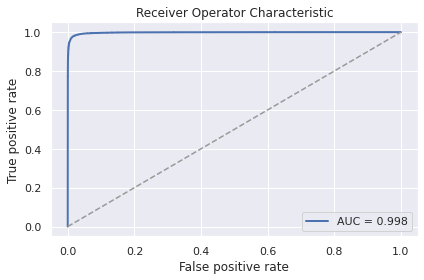

In [42]:
plt.plot(fpr_keras_test, tpr_keras_test, lw = 2, label = 'AUC = {:.3f}'.format(auc_keras_test))
plt.plot([0, 1], [0, 1],
         linestyle = '--',
         color = (0.6, 0.6, 0.6))
         #label = 'random guessing')
#plt.plot([0, 0, 1], [0, 1, 1],
#         linestyle = ':',
#         color = 'black', 
#         label = 'perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

Ampliação na região superior esquerda do gráfico auc do teste beta

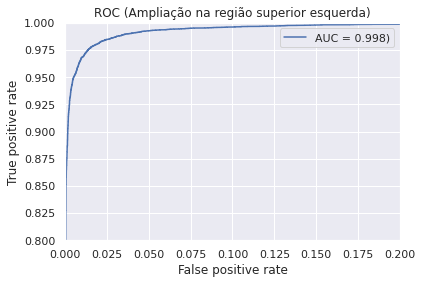

In [44]:
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_test, tpr_keras_test, label='AUC = {:.3f})'.format(auc_keras_test))
plt.plot([0, 0, 1], [0, 1, 1],
         linestyle = ':',
         color = 'black')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC (Ampliação na região superior esquerda)')
plt.legend(loc='best')
plt.show()

Matriz de confusão com elementros gráficos para o teste beta

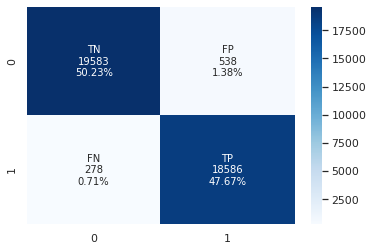

In [45]:
group_names = ['TN','FP','FN','TP']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [ ]:
src = cv2.imread('/content/2A_images/' + 'radiopaedia_40_86625_0-0082.png') #positve
#src = cv2.imread('/content/2A_images/' + 'CP_1462_4003_0011.png') #negative

#pra testar manualmente so precisa dar o resize e colocar no formato (1,224,224,3), o preprocess ja esta na arquitetura
#modelo
img = cv2.resize(src, (224,224))


#img = img/255
#img = tf.keras.applications.resnet50.preprocess_input(img)
#img.max(axis=(0, 1))
#img
img = np.expand_dims(img, axis=0)
resp = loaded_model.predict(img)
resp

In [ ]:
#/content/dataset_ct_tcc_gregory_v1/CT_COVID/2020.01.24.919183-p27-132.png #covid
#img = tf.keras.preprocessing.image.load_img('/content/dataset_ct_tcc_gregory_v1/CT_COVID/2020.01.24.919183-p27-132.png')
img = tf.keras.preprocessing.image.load_img('/content/2A_images/NCP_96_1328_0038.png')	
plt.imshow(img)
np.shape(img)

Dataframe para o conjunto de dados referente ao teste alpha que será passado ao modelo por dataframe

In [46]:
teste2_data_generator  = idg.flow_from_dataframe(df14, directory='/content/conjalpha/',
							x_col = "filename",  y_col = "label",
							class_mode = "binary", shuffle = False, target_size=(224,224), batch_size=1)

Found 541 validated image filenames belonging to 2 classes.


In [47]:
teste2_data_generator.class_indices

{'negativo': 0, 'positivo': 1}

Teste alpha

In [48]:
eval_test_2 = loaded_model.evaluate(teste2_data_generator)

541/541 [==============================] - 8s 14ms/step - loss: 1.1885 - tn: 149.0000 - fp: 45.0000 - fn: 145.0000 - tp: 202.0000 - accuracy: 0.6488 - precision: 0.8178 - recall: 0.5821 - auc: 0.7430


In [49]:
predicted_prob_test = loaded_model.predict(teste2_data_generator)
#predicted = (predicted > 0.5)
#predicted = np.where(predicted>0.5, 'N-COVID', 'COVID-19')
predicted_test = predicted_prob_test
predicted_test = np.where(predicted_test>0.5, 1, 0)

Matriz de confusão teste alpha

In [50]:
cm2 = confusion_matrix(teste2_data_generator.classes, predicted_test.ravel())
cm2

array([[149,  45],
       [145, 202]])

Matriz de confusão com elementos gráficos para o teste alpha

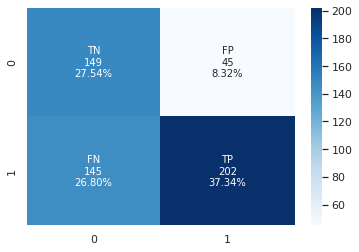

In [51]:
group_names = ['TN','FP','FN','TP']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm2.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm2.flatten()/np.sum(cm2)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm2, annot=labels, fmt='', cmap='Blues')

Métricas completas teste alpha

In [52]:
tn = eval_test_2[1]
fp = eval_test_2[2]
fn = eval_test_2[3]
tp = eval_test_2[4]

accuracy_test = (tp+tn)/(tp+tn+fp+fn)

sensitivity_test = tp/(tp+fn)
recall_test = tp/(tp+fn)

specificity_test = tn/(tn+fp)

precision_test = tp/(tp+fp)
f1_score_test = (2*(precision_test*recall_test))/(precision_test + recall_test)

tpr_test = tp/(tp+fn)
fpr_test = fp/(fp+tn)

print('TN: {} \nFP: {} \nFN: {} \nTP: {}'.format(tn,fp,fn,tp))

print('Accuracy: ' + str(accuracy_test))
print('Sensitivity: '+ str(sensitivity_test))
print('Specificity: '+ str(specificity_test))
print('Precision: '+ str(precision_test))
print('Recall: '+ str(recall_test))
print('F1-score: '+ str(f1_score_test))

print('TPR: '+ str(tpr_test))
print('FPR: '+ str(fpr_test))

TN: 149.0 
FP: 45.0 
FN: 145.0 
TP: 202.0
Accuracy: 0.6487985212569316
Sensitivity: 0.5821325648414986
Specificity: 0.7680412371134021
Precision: 0.8178137651821862
Recall: 0.5821325648414986
F1-score: 0.68013468013468
TPR: 0.5821325648414986
FPR: 0.23195876288659795


Calculo roc e auc para teste alpha

In [53]:
#passando porcentagem da predição para roc_curve
fpr_keras_test2, tpr_keras_test2, _ = roc_curve(teste2_data_generator.classes, predicted_prob_test.ravel())
auc_keras_test2 = auc(fpr_keras_test2, tpr_keras_test2)
print(auc_keras_test2)
print(tpr_keras_test2)
print(fpr_keras_test2)

0.7476900680352953
[0.         0.03170029 0.04322767 0.04899135 0.05475504 0.06340058
 0.06916427 0.13256484 0.13256484 0.15850144 0.15850144 0.16714697
 0.16714697 0.20461095 0.20461095 0.21613833 0.21613833 0.21902017
 0.21902017 0.24207493 0.24207493 0.25072046 0.25072046 0.26224784
 0.26224784 0.26801153 0.26801153 0.27665706 0.27665706 0.2795389
 0.2795389  0.29971182 0.29971182 0.31412104 0.31412104 0.32853026
 0.32853026 0.33429395 0.33429395 0.36311239 0.36311239 0.38616715
 0.38616715 0.39481268 0.39481268 0.40057637 0.40057637 0.4351585
 0.4351585  0.44668588 0.44668588 0.4610951  0.4610951  0.46685879
 0.46685879 0.46974063 0.46974063 0.47838617 0.47838617 0.49279539
 0.49279539 0.49855908 0.49855908 0.50720461 0.50720461 0.5129683
 0.5129683  0.51585014 0.51585014 0.52161383 0.52161383 0.52737752
 0.52737752 0.54755043 0.54755043 0.55331412 0.55331412 0.55907781
 0.55907781 0.56195965 0.56195965 0.58501441 0.58501441 0.60806916
 0.60806916 0.61095101 0.61095101 0.6167147  0

Montagem do gráfico de auc para o teste alpha

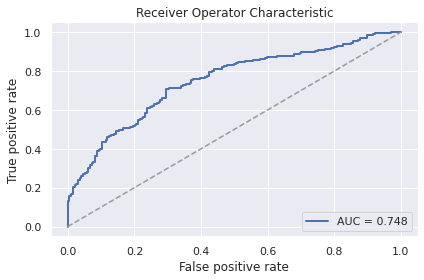

In [54]:
plt.plot(fpr_keras_test2, tpr_keras_test2, lw = 2, label = 'AUC = {:.3f}'.format(auc_keras_test2))
plt.plot([0, 1], [0, 1],
         linestyle = '--',
         color = (0.6, 0.6, 0.6))
         #label = 'random guessing')
#plt.plot([0, 0, 1], [0, 1, 1],
#         linestyle = ':',
#         color = 'black', 
#         label = 'perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()